In [1]:
# Project library Imports
from lc_tutorials.appearance.notebook import apply_custom_styles, cprint
from lc_tutorials.functionality.utils import setup_environment

# Standard library imports
import os
import sys
import json
import time
import uuid
import random
from typing import Annotated
from typing_extensions import TypedDict
from IPython.display import display, HTML, Markdown, Image, Javascript

# Third-party imports
from dotenv import load_dotenv, find_dotenv
from colorama import Back, Fore, Style, init
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph Imports
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.graph.state import CompiledStateGraph

# LangChain Imports
from langchain_core.messages import ToolMessage
from langchain_openai import ChatOpenAI


custom_style="""
<style>
/* General styles */
.result-container {
    max-width: 90%;
    margin: 1em 0;
}

/* Card Styling */
.result-card {
    background-color: #f8f9fa;
    border-left: 4px solid #05bfa5;
    border-radius: 8px;
    margin-bottom: 1em;
    overflow: hidden;
}

/* Header Styling */
.result-header {
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 0.8em 1em;
    font-family: 'Source Code Pro', monospace;
    font-weight: bold;
    font-size: 1.05em;
    color: #2c3e50;
    background-color: #e9ecef;
    cursor: pointer;
}

.result-header:hover {
    background-color: #dfe4ea;
}

/* Content Styling */
.result-content {
    display: none;
    padding: 0.8em 1em;
    font-family: 'Source Code Pro', monospace;
    font-size: 0.95em;
    color: #34495e;
}

/* Link Styling */
.result-link {
    text-decoration: none;
    color: #3498db;
    font-weight: bold;
}
</style>

<script>
// JavaScript function to toggle visibility of the result content and icon
function toggleContent(id, iconId) {
    var content = document.getElementById(id);
    var icon = document.getElementById(iconId);
    if (content.style.display === "none" || content.style.display === "") {
        content.style.display = "block";
        icon.innerHTML = "&#9660;";  // Change to down-facing arrow
    } else {
        content.style.display = "none";
        icon.innerHTML = "&#9654;";  // Change to right-facing arrow
    }
}
</script>
"""
apply_custom_styles(use_base=True, custom_style=custom_style)
setup_environment()


✅ Environment Variables Loaded Successfully



<div class="h1-container">

# 🚀 Quick Start <sub> ··· continued!</sub>

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

<div class="feature-list">

- 🧠 Answer common questions w/ a basic chatbot
- <span style="color: teal; font-weight: bold;">🔍 Answer common questions by searching the web [THIS NOTEBOOK]</span>
- 💾 Maintain conversation state across calls
- 🔄 Route complex queries to a human for review
- ⚙️ Use custom state to control its behavior
- 🌳 Rewind and explore alternative conversation paths

</div>

<br>

Previously we built a basic chatbot, we will now enhance our ChatBot with <b>tools</b>. 

</div>

<div class="h2-container">

## Part 2: Enhancing the Chatbot with Tools

Since our ChatBot can't answer "from memory" we will integrate a <a href="https://python.langchain.com/docs/integrations/tools/tavily_search/"><b>web search tool</b></a> to find relevant information and provide better responses.

<div class="notice-block">
    <h4 style="margin-top: 0; color: #ff5722;">PREREQUISITE REQUIREMENT!</h4>
    <p>
        We need to install the requirements to use the <a href="https://python.langchain.com/docs/integrations/tools/tavily_search/"><b>Tavily Search Engine</b></a>, and we need to add the <b>Tavily API Key</b> to the <code class="code-mention">.env</code> file in our codebase (or pass it directly).
    </p>
</div>

<div class="h3-container">

### 🚀 Quick Intro to Tools

<br>

<div class="note-block">
    <p class="note-title">📌 Overview</p>
    <p>In LangChain, tools are components that allow an agent or language model to perform specific actions, such as interacting with APIs or retrieving external data.</p>
    <b>Tools are composed of the following components:</b>
    <ul>
        <li><strong>Name & Description:</strong> Defines the tool and clarifies its purpose for the language model.</li>
        <li><strong>Input Schema:</strong> JSON schema that outlines the required inputs for the tool.</li>
        <li><strong>Execution Function:</strong> The function the tool calls to perform the action.</li>
        <li><strong>Return Options:</strong> Optionally specifies if the results should return directly to the user.</li>
    </ul>
</div>

---

<div class="notice-block">
    <span class="highlight">💡 Tip:</span> Simplifying the input schema to a single string makes the tool easier for an LLM to use.
</div>

<br>

<b>🔧 Working with TavilySearchEngine</b>

We will now initialize our tool to interact with the Tavily search API, enabling our ChatBot to query and retrieve results directly from the internet.

The results are page summaries (and the respective URL) that our ChatBot can use to answer questions.

<br>

</div>

In [74]:
# Function to format and display results as HTML
def display_tavily_search_results(results: list[dict[str, str]]) -> None:
    """Displays the tavilty search results in a visually formatted HTML structure within our notebook.

    This function takes a list of search results, formats each result into a styled HTML 
    "card," and displays it in a Jupyter notebook. Each card includes the URL as a clickable 
    link and a content snippet. We added the CSS for this rendering in the first cell of the NB.

    Args:
        results (list[dict[str, str]]): 
            A list of dictionaries containing 'url' and 'content' keys, where:
                - 'url' (str): The link to the search result.
                - 'content' (str): A short snippet or description of the result.

    Returns:
        None; The function outputs HTML directly in our notebook and does not return any value.
    """

    # Generate a unique prefix to ensure unique IDs
    unique_prefix = str(uuid.uuid4()).replace("-", "")
    
    # Begin constructing the HTML content
    html_content = "<div class='result-container'>"
    
    # Iterate through the results
    for idx, result in enumerate(results):
        # Each result gets a unique ID for the collapsible functionality
        content_id = f"result-content-{unique_prefix}-{idx}"
        icon_id = f"icon-{unique_prefix}-{idx}"
        html_content += f"""
        <div class="result-card">
            <div class="result-header" onclick="toggleContent('{content_id}', '{icon_id}')">
                <span>URL:</span> <a href="{result['url']}" target="_blank" class="result-link">{result['url']}</a>
                <span id="{icon_id}" style="float: right;">&#9654;</span>  <!-- Right-facing arrow initially -->
            </div>
            <div id="{content_id}" class="result-content">
                <p style="font-family: Montserrat"><strong>CONTENT:</strong><br><br> {result['content']}</p>
            </div>
        </div>
        """
    html_content += "</div>"
    
    # Display the final HTML with CSS and JavaScript
    display(HTML(html_content))


# Instantiate the TavilySearchResults tool, configuring it to return up to 2 results per query.
tool = TavilySearchResults(max_results=3)

# Create a list of tools for potential use with agents or workflows, here containing just the TavilySearchResults tool.
tools = [tool]

# Invoke the tool with a query asking about the term "node" in the context of LangGraph.
# This sends the query to the Tavily search API and retrieves information based on the configuration.
results = tool.invoke("What's a 'node' in LangGraph and LangChain?")

# Display the results
cprint("\nORIGINAL RESULTS\n", fg_color="red", bold=True)
_ = display(results)

# Display the results
cprint("\nORIGINAL RESULTS\n", fg_color="red", bold=True)
_ = display_tavily_search_results(results)


ORIGINAL RESULTS



[{'url': 'https://cobusgreyling.medium.com/langgraph-from-langchain-explained-in-simple-terms-f7cd0c12cdbf',
  'content': 'LangGraph. Again considering the image blow, a snippet of LangGraph Python code is shown on the left, with the graph drawn out on the right. You can see in the code where the node is defined, builder.add_node with a ReturnNodeValue.For each node having an edge defined builder.add_edge.. You also see that a is set as the entry_point and d as the finish_point.'},
 {'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': 'LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing'},
 {'url': 'https://langchain-ai.github.io/langgraph/',
  'content': 'Overview. LangGra


ORIGINAL RESULTS



<div class="h3-container">
    
### 📈 Defining the Graph with Tool Binding

<p>Now, we’ll start defining our graph. This setup is similar to <strong>Part 1</strong>, with the addition of the <code class="code-mention">bind_tools</code> method applied directly to our LLM.

<p>By binding tools to our LLM, we allow it to generate output in the correct JSON format whenever it calls our search engine tool.</p>

</div>

In [28]:
class State(TypedDict):
    """Defines the state schema for the chatbot graph.
    
    Attributes:
        messages (Annotated[list, add_messages]): List of conversation messages.
            Uses add_messages reducer to append rather than overwrite messages.
    """
    messages: Annotated[list, add_messages]
    

def initialize_graph():
    """Initialize the StateGraph with the defined State schema.
    
    Returns:
        StateGraph: Configured graph builder instance
    """
    return StateGraph(State)


def chatbot(state: State) -> dict:
    """Process the current state and generate a response using the language model.
    
    Args:
        state (State): Current state containing conversation messages
        
    Returns:
        dict: Updated state with new message appended
    """
    return {"messages": [llm.invoke(state["messages"])]}

# Initialize the graph builder
graph_builder = initialize_graph()

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o")
llm = llm.bind_tools(tools)

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

print(graph_builder)
display(graph_builder.__dict__)

{'nodes': {'chatbot': StateNodeSpec(runnable=chatbot(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.State'>, retry_policy=None)},
 'edges': set(),
 'branches': defaultdict(dict, {}),
 'support_multiple_edges': False,
 'compiled': False,
 'schemas': {__main__.State: {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x123196a00>}},
 'channels': {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x123196a00>},
 'managed': {},
 'schema': __main__.State,
 'input': __main__.State,
 'output': __main__.State,
 'config_schema': None,
 'waiting_edges': set()}

<div class="h3-container">

### 🔧 Implementing Tool Execution with Basic Tool Nodes

<p>Next, we’ll implement a function to handle tool execution when invoked. This involves <b>creating a new node</b> to add our tools to the graph. Recall that a <b>node</b> is an LLM or function that our chatbot can call.</p>

<p>Below, we define a <code class="code-mention">BasicToolNode</code> that inspects the latest message in the state for any <code class="code-mention">tool_calls</code>. If detected, the node triggers the appropriate tools, leveraging <strong>tool_calling</strong> capabilities supported across major LLM providers, including Anthropic, OpenAI, and Google Gemini.</p>

<p>Though we’ll eventually use LangGraph’s prebuilt <a href="https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode" target="_blank" class="link">ToolNode</a> for efficiency, building this node ourselves first will enhance our understanding of the process.</p>

</div>

In [29]:
class BasicToolNode:
    """Executes tools based on the latest tool call from an AI message.

    Attributes:
        tools_by_name (dict): 
            Dictionary mapping tool names to their instances.
            This enables efficient lookup and invocation of tools by name.
    """

    def __init__(self, tools: list) -> None:
        """Initializes BasicToolNode with a list of tools.

        The tools are stored in a dictionary for quick access by their name.

        Args:
            tools (list): 
                List of tool instances to be used for processing tool calls.
                Each tool should have a unique `name` attribute and an `invoke` method.

        """
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict) -> dict:
        """Processes the latest message and executes any requested tools.

        Args:
            inputs (dict): 
                A dictionary containing a list of messages under the "messages" key.
                Expects each message to potentially include tool call data.

        Returns:
            dict: A dictionary containing the tool results appended as new messages.

        Raises:
            ValueError: If no message is found in the inputs.
        """
        # Retrieves the most recent message and handle errors for missing messages
        if messages := inputs.get("messages", []):
            message = messages[-1]  
        else:
            raise ValueError("No message found in input")

        # Initialize the outputs
        outputs = []
        for tool_call in message.tool_calls:
            # Invoke the tool based on its name and the arguments provided in tool_call
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # Construct a ToolMessage with the tool's output in JSON format
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# The functionality is packaged as a tool node
tool_node = BasicToolNode(tools=[tool])

# We add this node to our graph
graph_builder.add_node("tools", tool_node)

print(graph_builder)
display(graph_builder.__dict__)

{'nodes': {'chatbot': StateNodeSpec(runnable=chatbot(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.State'>, retry_policy=None),
  'tools': StateNodeSpec(runnable=tools(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.State'>, retry_policy=None)},
 'edges': set(),
 'branches': defaultdict(dict, {}),
 'support_multiple_edges': False,
 'compiled': False,
 'schemas': {__main__.State: {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x123196a00>}},
 'channels': {'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x123196a00>},
 'managed': {},
 'schema': __main__.State,
 'input': __main__.State,
 'output': __main__.State,
 'config_schema': None,
 'waiting_edges': set()}

<div class="h3-container">

### 🔀 Defining Conditional Edges for Dynamic Routing

<p>With the tool node in place, we can now set up <code class="code-mention">conditional_edges</code> to control the flow dynamically based on specific conditions.</p>

<p>Recall that <strong>edges</strong> direct control flow between nodes. <strong>Conditional edges</strong> introduce logic, often using “if” statements, to determine the next node based on the current graph <code class="code-mention">state</code>. These functions take the graph state and return a string or list of strings indicating the next node(s) to invoke.</p>

<p>Below, we define a router function, <code class="code-mention">route_tools</code>, which examines the chatbot's output for any <code class="code-mention">tool_calls</code>. We pass this function to the graph using <code class="code-mention">add_conditional_edges</code>, directing the graph to check this function each time the <code class="code-mention">chatbot</code> node completes to determine the next step.</p>

<p>If tool calls are detected, the condition routes to <code class="code-mention">tools</code>; otherwise, it routes to <code class="code-mention">END</code>.</p>

<p>Later, we’ll streamline this with the prebuilt <b><a href="https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition" target="_blank" class="link">tools_condition</a></b> for a more concise setup, but implementing it ourselves first clarifies the underlying process.</p>

</div>

In [30]:
def get_latest_message(state: State):
    """Retrieve the latest message from the state.

    Args:
        state (State): Current state containing conversation messages.

    Returns:
        AIMessage: The most recent AIMessage in the state.

    Raises:
        ValueError: If no messages are found in the provided state.
    """
    # If the `state` is a list, assume it contains messages directly
    # and return the last item in the list (most recent message).
    if isinstance(state, list):
        return state[-1]
    
    # If `state` is a dictionary, attempt to retrieve the list of messages
    # using the "messages" key. If found, return the last message.
    elif messages := state.get("messages", []):
        return messages[-1]
    
    # If neither of the above conditions are met, raise an error.
    # This ensures that the function only proceeds when a valid list
    # of messages is found, either as a direct list or within a dictionary.
    else:
        raise ValueError("No messages found in the provided state.")

def is_message_a_tool_call(message):
    return hasattr(message, "tool_calls") and len(message.tool_calls) > 0

def route_tools(state: State) -> str:
    """Route to ToolNode if the last message contains tool calls; otherwise, route to the end node.

    This function is used within a conditional edge to determine whether the 
    conversation should proceed to a ToolNode based on the presence of tool calls 
    in the last AIMessage. If tool calls are detected, it returns 'tools' to signal 
    that the graph should invoke the ToolNode; if not, it returns 'END'.

    Args:
        state (State): Current state containing conversation messages.

    Returns:
        str: "tools" if tool calls are detected; otherwise, "END".
    """
    # Retrieve the latest AI message
    ai_message = get_latest_message(state)  

    # Check if `tool_calls` attribute exists and has something in it...
    if is_message_a_tool_call(ai_message):
        return "tools"

    # Otherwise we end
    return END


# Setting up the graph with conditional routing based on tool calls
#   - `source` (str): The starting node. 
#        --> This conditional edge will run when exiting this node.
#   - `path` (Union[Callable, Runnable]): 
#        --> The callable that determines the next node or nodes. 
#        --> If not specifying `path_map` it should return one or more nodes. 
#        --> If it returns END, the graph will stop execution.
#   - `path_map` (Optional[dict[Hashable, str]]): 
#        --> Optional mapping of paths to node names. 
#        --> If omitted the paths returned by `path` should be node names.
#   - `then` (Optional[str]): 
#        --> The name of a node to execute after the nodes selected by `path`.
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    path_map= {
        "tools": "tools",  # Directs to "tools" node if route_tools returns "tools"
        END: END           # Directs to the END if no tool calls are detected
    }
)

# Adding edges to define graph flow:
#   (1) From the "tools" node back to "chatbot" for further processing after tool execution
#   (2) From the start node to the "chatbot" node to initiate the conversation
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Compile the graph with the defined nodes, edges, and conditions
graph = graph_builder.compile()

<div class="h3-container">

### 📌 Key Details on Conditional Edge Behavior

<p><strong>Notice</strong> how conditional edges originate from a single node. This setup instructs the graph: whenever the <code class="code-mention">chatbot</code> node completes, it should either proceed to <code class="code-mention">tools</code> if a tool call is detected, or end the loop if the response is direct.</p>

<p>Similar to the prebuilt <code class="code-mention">tools_condition</code>, our function returns the <code class="code-mention">END</code> string when no tool calls are present. Transitioning to <code class="code-mention">END</code> signals that there are no remaining tasks, stopping graph execution. Since this condition covers <code class="code-mention">END</code>, we don’t need to define an explicit <code class="code-mention">finish_point</code>; the graph inherently knows when to finish!</p>

<p>Let’s visualize the graph structure we’ve created. Note that the function below has additional dependencies that aren't critical to cover in this tutorial.</p>

</div>


🧜‍♀️ Mermaid Chart for Our Graph



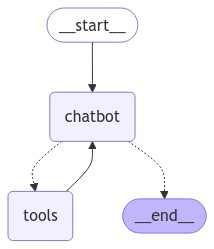

In [31]:
cprint("\n🧜‍♀️ Mermaid Chart for Our Graph\n", fg_color="blue", bold=True)
display(Image(graph.get_graph().draw_mermaid_png()))

<div class="h3-container">

### 🤖 Running Your Chatbot

Let's run our bot...<br><b>We can now ask the bot questions outside its training data!</b><br><br>We've added some prettified features to make things look a bit better...

<div class="feature-list">

- 🎯 Interactive chat interface with colorized output
- 🚪 Multiple exit commands supported
- 🛡️ Error handling and graceful fallbacks
- 🔄 Stream-based response processing
- 💬 Message history tracking

</div>

</div>


In [75]:
def run_interactive_chat(graph: CompiledStateGraph) -> None:
    """Run the interactive chat interface with enhanced printing capabilities.

    Args:
        graph (CompiledStateGraph): The compiled LangGraph instance
    """
    EXIT_COMMANDS = {"quit", "exit", "q", "bye", "goodbye"}
    message_history = []
    
    # Display welcome banner
    cprint("\n"+"="*50, fg_color="blue", bold=True)
    cprint("🦜 Welcome to LangGraph Chat!", fg_color="yellow", bold=True)
    cprint("Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation", fg_color="white", bold=True)
    cprint("="*50+"\n", fg_color="blue", bold=True)

    # Start interaction loop
    while True:
        try:
            # Get user input with styled prompt
            user_input = input("\nUser Input: ")
            
            # Check for exit command
            if user_input.lower() in EXIT_COMMANDS:
                cprint("\n👋 Goodbye! Thanks for chatting!\n", fg_color="yellow", bold=True)
                break
            
            # Process user message through graph
            message_history.append(("user", user_input))
            
            try:
                for event in graph.stream({"messages": message_history}):
                    for value in event.values():

                        # Define what we are working with here
                        last_message = value["messages"][-1]
                        response = last_message.content

                        # Check which flavour of message it is...
                        if is_message_a_tool_call(last_message):
                            response_type = "tool_calls"
                            cprint(f"\n🦾 LLM has decided to use the tool named '{last_message.tool_calls[0]["name"]}'\n", fg_color="blue", bold=True)
                        elif hasattr(last_message, "tool_call_id"):
                            display_tavily_search_results(json.loads(response))
                        else:
                            cprint(text=response, prefix_text="\nAssistant: ", fg_color="green", bold_prefix=True)
                        message_history.append(("assistant", response))
            except Exception as e:
                cprint(f"Error processing message: {str(e)}", bg_color="red", bold=True)
        
        except KeyboardInterrupt:
            cprint("\nChat session interrupted. 👋 Goodbye!", fg_color="yellow", bold=True)
            return message_history
        except Exception as e:
            cprint("\nSomething went wrong. 👋 Goodbye!", fg_color="yellow", bold=True)
            return message_history

message_history = run_interactive_chat(graph)


🦜 Welcome to LangGraph Chat!
Type 'quit', 'exit', 'bye', 'goodbye', or 'q' to end the conversation




User Input:  What is LangGraph and what are the criticisms it faces?



🦾 LLM has decided to use the tool named 'tavily_search_results_json'




🦾 LLM has decided to use the tool named 'tavily_search_results_json'




Assistant: LangGraph is a framework designed for building stateful, multi-actor applications with large language models (LLMs). It aims to manage complex scenarios and facilitate collaboration between AI agents and humans. LangGraph is part of the LangChain ecosystem and enhances the development of multi-agent workflows by integrating tools such as LangChain, LangSmith, and Anthropic. It focuses on creating flexible, scalable systems through the use of nodes, edges, and state management, and can be deployed with LangGraph Cloud for real-world applications.

### Criticisms of LangGraph
1. **Autonomy vs. Control**: A major criticism of LangGraph, and similar agent frameworks, is the high level of autonomy given to agents. While this allows for greater flexibility, it also results in a lack of control for the developers or users. Many users desire a balance where they can maintain some level of control over the agents.
   
2. **Complexity in Workflow**: While LangGraph provides a more gr

<div class="h3-container">
  <h3 style="color: #2563eb; display: flex; align-items: center; gap: 0.5rem;">
    🎉 Congratulations!
  </h3>
  
  <p>You've successfully enhanced your LangGraph chatbot with search capabilities! This implementation includes:</p>
  
  <div style="margin-left: 1rem;">
    <h4 style="color: #4b5563; margin-bottom: 0.5rem;">1. Search Integration</h4>
    <ul style="margin-top: 0;">
      <li>Real-time web search capabilities</li>
      <li>Dynamic information retrieval</li>
      <li>Broader query handling</li>
    </ul>
  </div>

  <div class="notice-block" style="background-color: #f3f4f6; border-left: 4px solid #2563eb; padding: 1rem; margin: 1rem 0; border-radius: 0.375rem;">
    <h4 style="margin-top: 0; color: #dc2626;">🔍 What's Next</h4>
    <p style="margin-bottom: 0;">In the upcoming section, we'll implement:</p>
    <ul style="margin-bottom: 0;">
      <li>Memory management for multi-turn conversations</li>
      <li>Enhanced conversation coherence</li>
      <li>Persistent context handling</li>
    </ul>
  </div>

  <p>Want to see how your chatbot processes queries? Check out the <a href="https://smith.langchain.com/public/4fbd7636-25af-4638-9587-5a02fdbb0172/r" style="color: #2563eb; text-decoration: underline;"><b>LangSmith trace</b></a>!</p>

<div class="code-block" style="margin-top: 1rem;">
<details>
<summary style="cursor: pointer; color: #2563eb; font-weight: bold;">📚 Complete Implementation</summary>

<br>      

```python      
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()</code></pre>
```

</details>
</div>
</div>